# **SIIM-ACR Pneumothorax Segmentation**

***Business Problem:***

Pneumothorax is a medical condition which arises when air leaks into the space between the lung and the chest wall. This air pushes on the outside of the lung and makes it collapse. Thus, pneumothorax can be a complete lung collapse or a portion of the lungs may be collapsed. Pneumothorax can be caused by a blunt chest injury, damage from underlying lung disease, or sometimes for no obvious reason at all. It can be a life-threatening event.

Pneumothorax is usually diagnosed by a radiologist on a chest x-ray, and can sometimes be very difficult to confirm. The problem that this case study is dealing with predicts whether the condition exists in the chest x-ray image given and if present it segments the portion of the lungs that is affected. An accurate prediction would be useful in a lot of clinical scenarios to triage chest radiographs for priority interpretation, or to provide a more confident diagnosis for non-radiologists.

***Mapping the real world problem as a Deep Learning problem:***

The data is comprised of images in DICOM format containing run-length-encoded (RLE) masks. The instances of pneumothorax are indicated by encoded binary masks in the annotations. Some training images have multiple annotations depicting the multiple locations of the event. Images without pneumothorax have a mask value of -1. The task is to predict the mask of pneumothorax in the given X-ray image. This task can be mapped as a Semantic Image Segmentation problem.

***Data set Analysis:***

1) Files given: train-rle.csv, stage_2_sample_submission.csv (test_data), 
train_images, test_images.

2) Total File Size : 4GB

3) Total number of records: 12,954 (train_data), 3204 (test_data)

4) The train-rle.csv contains image IDs and their corresponding RLE masks and the test csv file only contains the image IDs.

***Real World Business Constraints:***

a) Low latency is important.

b) Mis-classification/ mis-segmentation cost is considerably high as we are dealing with medical data and thus it is very sensitive to such errors.

***Performance Metric:***

1) Dice Coefficient (IntersectionOverUnion/IOU)

2)  Combo Loss – (Binary Cross Entropy + Dice Loss/ F1 loss)

3)  Confusion Matrix

# **Importing Libraries :**

In [ ]:
# Mounting the Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Installing pydicom

!pip install pydicom

You should consider upgrading via the 'c:\users\namratat\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
#installing the libraries:

import pandas as pd
import numpy as np
import pydicom
from glob import glob
import glob2
from tqdm import tqdm
import shutil
import os
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
from joblib import Parallel, delayed
import os
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/drive/MyDrive/Self \Case \Study \2/DATASET/ 

/content/drive/MyDrive/Self Case Study 2/DATASET


In [5]:
%cd C:\Users\NamrataT\Desktop\CS_2\DATASET\

C:\Users\NamrataT\Desktop\CS_2\DATASET


In [6]:
os.getcwd()

'C:\\Users\\NamrataT\\Desktop\\CS_2\\DATASET'

# **Exploratory Data Analysis**

***Loading the Train Data :***

In [13]:
train_df = pd.read_csv(r'Train Dataset\siim\train-rle.csv')
train_df.head(2)

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...   
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...   

                                       EncodedPixels  
0                                                 -1  
1  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...

In the .csv file provided, we see that there is information about the images in the form of individual ***ImageId*** and its corresponding ***EncodedPixels*** , i.e. the RLE (Run Length Encoding of the masks).

In [ ]:
print('The Shape of the Dataset : ',train_df.shape)
train_df.describe()

The Shape of the Dataset :  (12954, 2)


ImageId  EncodedPixels
count                                               12954          12954
unique                                              12047           3577
top     1.2.276.0.7230010.3.1.4.8323329.1851.151787516...             -1
freq                                                   10           9378

We have a total of 12954 train images. Out of these we have some duplicates as evident from above.

In [ ]:
print(' There are total {} records that are duplicate.'.format(train_df['ImageId'].count() - train_df['ImageId'].nunique()))

 There are total 907 records that are duplicate.


Dropping the duplicate records from the .csv file.

In [ ]:
train_df.drop_duplicates(subset = 'ImageId',inplace=True)
print('Total Unique Rows : ',train_df.shape[0])

Total Unique Rows :  12047


In [33]:
train_df.drop_duplicates(subset = 'ImageId',inplace=True)
print('Total Unique Rows : ',train_df.shape[0])

Total Unique Rows :  12047


After dropping the duplicates we see that we have a total of 12,047 unique images.

Let's create the directories that will hold all the train and test images.

In [ ]:
train_source = 'Train Dataset/siim/dicom-images-train/**/*.dcm'
test_source = 'Train Dataset/siim/dicom-images-test/**/*.dcm'

# Create Directories to move files
train_destination = 'Train Dataset/siim/train_dicom_images'
test_destination = 'Train Dataset/siim/test_dicom_images'

if not os.path.isdir(train_destination):
  os.makedirs(train_destination)
if not os.path.isdir(test_destination):
  os.makedirs(test_destination) 

In the data that is provided, we see that each image is present in a separate folder. We need to move those images from its individual folder to a common directory that will hold all the images together.

In [ ]:
#https://stackoverflow.com/questions/8858008/how-to-move-a-file

def move_images(source, dest):
    '''
    This function takes the source and destination path as arguments and 
    move the files from source to destination.
    '''
    print(source)
    print(dest)
    for file in tqdm(glob2.glob(source)):
        shutil.move(str(file),dest)

move_images(train_source, train_destination)
move_images(test_source, test_destination)

Train Dataset/siim/dicom-images-train/**/*.dcm
Train Dataset/siim/train_dicom_images


100%|██████████| 12089/12089 [00:53<00:00, 225.24it/s]


Train Dataset/siim/dicom-images-test/**/*.dcm
Train Dataset/siim/test_dicom_images


100%|██████████| 3205/3205 [00:12<00:00, 249.26it/s]


In [ ]:
print('Train Image :\n', os.listdir('Train Dataset/siim/train_dicom_images')[:2])
print('\nTest Image :\n', os.listdir('Train Dataset/siim/test_dicom_images')[:2])

Train Image :
 ['1.2.276.0.7230010.3.1.4.8323329.10425.1517875223.660376.dcm', '1.2.276.0.7230010.3.1.4.8323329.10419.1517875223.626705.dcm']

Test Image :
 ['ID_de91b6f09.dcm', 'ID_db54d1349.dcm']


Let's save the file path for each image in the .csv as a separate column. This will help us in accessing the images easily in the later stages.

In [25]:
path = "Train Dataset\\siim\\train_dicom_images\\"

In [26]:
train_df['ImagePath'] = path + train_df['ImageId'] +'.dcm'

In [ ]:
train_df['ImagePath'] = 'Train Dataset/siim/train_dicom_images/'+ train_df['ImageId']+'.dcm'

In [ ]:
#Saving the current train dataframe in a .csv file :

train_df.to_csv('Train Dataset/siim/train_dicom_images.csv', index=False)
train_df.head()

ImageId  ...                                          ImagePath
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...  ...  Train Dataset/siim/train_dicom_images/1.2.276....
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...  ...  Train Dataset/siim/train_dicom_images/1.2.276....
2  1.2.276.0.7230010.3.1.4.8323329.11028.15178752...  ...  Train Dataset/siim/train_dicom_images/1.2.276....
3  1.2.276.0.7230010.3.1.4.8323329.10366.15178752...  ...  Train Dataset/siim/train_dicom_images/1.2.276....
4  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...  ...  Train Dataset/siim/train_dicom_images/1.2.276....

[5 rows x 3 columns]

In [ ]:
train_df = pd.read_csv('Train Dataset/siim/train_dicom_images.csv')
train_df.head(2)

ImageId  ...                                          ImagePath
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...  ...  Train Dataset/siim/train_dicom_images/1.2.276....
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...  ...  Train Dataset/siim/train_dicom_images/1.2.276....

[2 rows x 3 columns]

In [28]:
train_df.head(2)

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...   
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...   

                                       EncodedPixels  \
0                                                 -1   
1  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...   

                                           ImagePath  
0  Train Dataset\siim\train_dicom_images\1.2.276....  
1  Train Dataset\siim\train_dicom_images\1.2.276....

***Loading the Test Data :***

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Self Case Study 2/DATASET/Test Dataset/stage_2_sample_submission.csv')
test_df.head(2)

ImageId  EncodedPixels
0  ID_c68e114ba             -1
1  ID_b5a797789             -1

In [ ]:
print('Total number of records in test data : ', test_df.shape[0])

Total number of records in test data :  3205


We have a total of 3205 records as test data.

Since the EncodedPixels column is our target variable so by default it is given as -1. Since it's useless right now so let's drop it.

In [ ]:
test_df = test_df.drop('EncodedPixels', axis=1)

Let's again save the file path for each image in the .csv as a separate column. This will help us in accessing the test images easily in the prediction stages.

In [ ]:
test_df['ImagePath'] = 'Train Dataset/siim/test_dicom_images/'+ test_df['ImageId']+'.dcm'

In [ ]:
#Saving the current test dataframe in a .csv file :

test_df.to_csv('Train Dataset/siim/test_dicom_images.csv', index=False)
test_df.head()

ImageId                                          ImagePath
0  ID_c68e114ba  Train Dataset/siim/test_dicom_images/ID_c68e11...
1  ID_b5a797789  Train Dataset/siim/test_dicom_images/ID_b5a797...
2  ID_490a04f54  Train Dataset/siim/test_dicom_images/ID_490a04...
3  ID_823ca20e1  Train Dataset/siim/test_dicom_images/ID_823ca2...
4  ID_5face2763  Train Dataset/siim/test_dicom_images/ID_5face2...

In [ ]:
test_df = pd.read_csv('Train Dataset/siim/test_dicom_images.csv')
test_df.head(2)

ImageId                                          ImagePath
0  ID_c68e114ba  Train Dataset/siim/test_dicom_images/ID_c68e11...
1  ID_b5a797789  Train Dataset/siim/test_dicom_images/ID_b5a797...

**Analysis of DICOM Images :**

We have files in .dcm format. This format is commonly used in medical imaging field and is known as DICOM(Digital Imaging and Communications in Medicine). Nearly all forms of medical imaging have become digitized noawdays and DICOM is the file format that is being used for storing such images ( e.g.: X-ray scan, an CT-scan ) along with the metadata.

Let's plot some of the images to see how they look like.

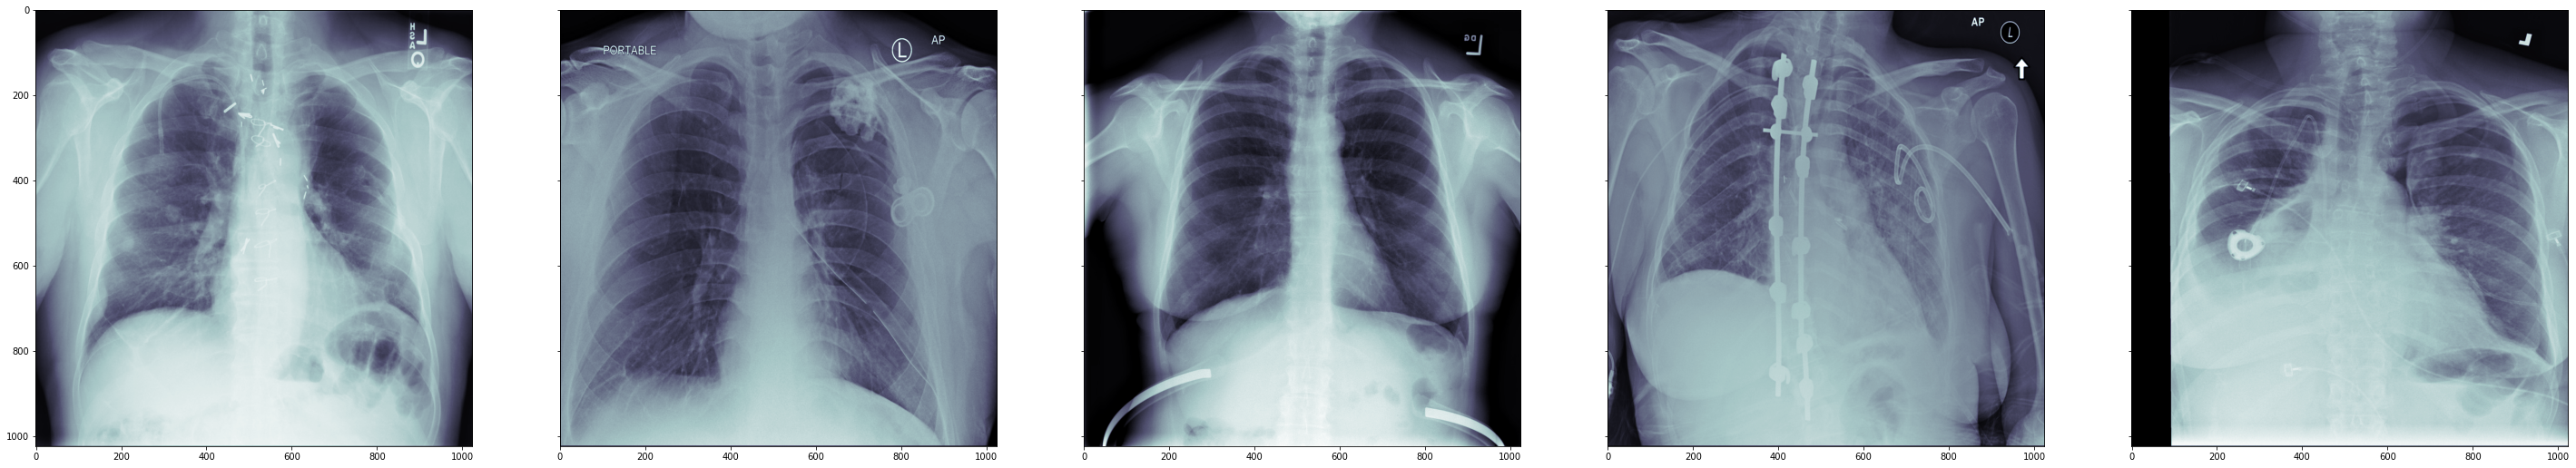

In [ ]:
# Plotting some of the images using the python package : pydicom

fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(5*10,10))
for i in range(5):
    train_image = pydicom.dcmread(train_df['ImagePath'][i])
    ax[i].imshow(train_image.pixel_array, cmap=plt.cm.bone)

Let's examine one image in detail to see the type of metadata that it stores.

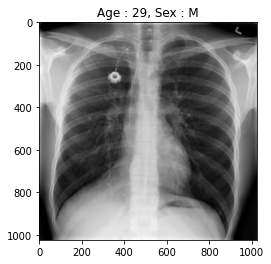

In [ ]:
# Plotting one image :

train_image = pydicom.read_file(train_df['ImagePath'][20])
plt.title("Age : {}, Sex : {}".format(train_image.PatientAge, train_image.PatientSex))
plt.imshow(train_image.pixel_array,cmap=plt.cm.gray)

Checking the metadata of the above image :

In [ ]:
print('Meta Data of the Image :\n')
train_image

Meta Data of the Image :



Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.32060.1517875158.251634
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.32060.1517875158.251634
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Let's store the properties like **Age**, **Sex**, **Modality** and **View** **Position** for each image so that we can use these to analyse the quality of data that we have.

In [ ]:
# Storing the above mentioned properties of each image in their individual lists :

age = []
gender = []
modality = []
viewPosition = []

for img in tqdm(train_df['ImagePath']):
    dcmImage = pydicom.dcmread(img)
    age.append(dcmImage.PatientAge)
    gender.append(dcmImage.PatientSex)
    modality.append(dcmImage.Modality)
    viewPosition.append(dcmImage.ViewPosition)

Let's create a dataframe containing the above meta information of each image so that we can do EDA on it.

In [ ]:
train_metaData = pd.DataFrame()
train_metaData['ImageId'] = train_df['ImageId']
train_metaData['Gender'] = gender
train_metaData['Age'] = age
train_metaData['Modality'] = modality
train_metaData['ViewPosition'] = viewPosition
train_metaData['Pneumothorax'] = train_df[' EncodedPixels'].apply(lambda x: 'No' if x=='-1' else 'Yes')
train_metaData.head()

ImageId  ... Pneumothorax
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...  ...           No
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...  ...          Yes
2  1.2.276.0.7230010.3.1.4.8323329.11028.15178752...  ...           No
3  1.2.276.0.7230010.3.1.4.8323329.10366.15178752...  ...          Yes
4  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...  ...          Yes

[5 rows x 6 columns]

Let's save the above dataframe into a .csv file 

In [ ]:
train_metaData.to_csv('Train Dataset/siim/train_metaData.csv', index=False)

In [ ]:
train_metaData = pd.read_csv('Train Dataset/siim/train_metaData.csv')

Let's do EDA on the above meta information.

In [ ]:
gender = train_metaData['Gender'].value_counts()
mod = train_metaData['Modality'].value_counts()
viewPos = train_metaData['ViewPosition'].value_counts()
target = train_metaData['Pneumothorax'].value_counts()

***Analysing the Gender :***

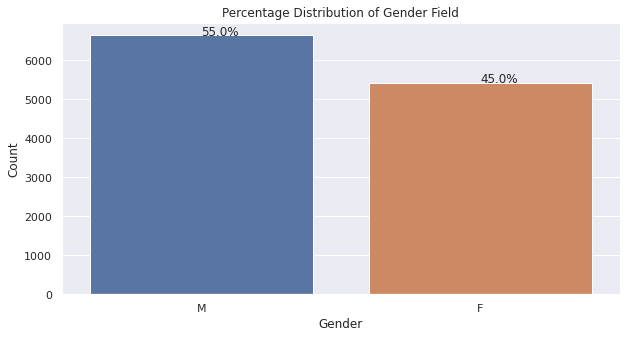

In [ ]:
#Plotting the Gender:

plt.figure(figsize=(10,5))
sns.set(style='darkgrid')
sns.countplot('Gender', data=train_metaData, order=train_metaData['Gender'].value_counts().index)
for i in range(gender.shape[0]):
    range_count = gender[i]
    per = round(((range_count*100)/train_metaData.shape[0]),2)
    percent='{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Percentage Distribution of Gender Field')
plt.show()

We have a majority of Male (**M**) Gender with 55% of the records. Female (**F**) consists of the remaining 45% of the records. We have only these two Genders represented in the data provided.

***Analysing the Target (Occurence of Pneumothorax) :***

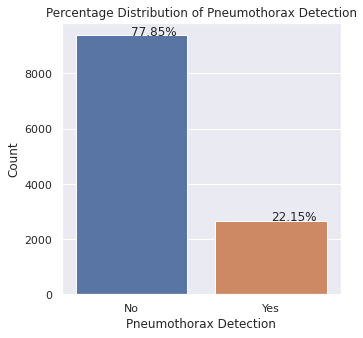

In [ ]:
#Plotting the Target variable :

plt.figure(figsize=(5,5))
sns.set(style='darkgrid')
sns.countplot('Pneumothorax', data=train_metaData, order=train_metaData['Pneumothorax'].value_counts().index)
for i in range(target.shape[0]):
    range_count = target[i]
    per = round(((range_count*100)/train_metaData.shape[0]),2)
    percent='{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Pneumothorax Detection')
plt.ylabel('Count')
plt.title('Percentage Distribution of Pneumothorax Detection')
plt.show()

As expected, majority of the records (77.85%) do not have any pneumothorx occurence recorded. A small percentage (22.15%) of records have the disease. 

Considering the fact that this is a medical data, it is quite expected that it will be heavily imbalanced as it reflects the real world scenario where majority of the patients who get an X-Ray doesnt have the mentioned disease.

***Analysing the ViewPosition Parameter :***

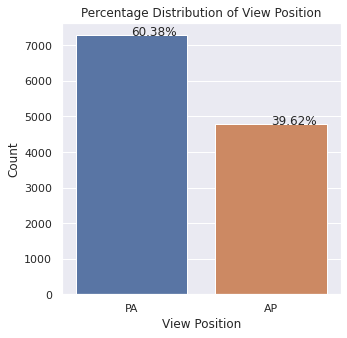

In [ ]:
#Plotting the ViewPosition variable :

plt.figure(figsize=(5,5))
sns.set(style='darkgrid')
sns.countplot('ViewPosition', data=train_metaData, order=train_metaData['ViewPosition'].value_counts().index)
for i in range(viewPos.shape[0]):
    range_count = viewPos[i]
    per = round(((range_count*100)/train_metaData.shape[0]),2)
    percent='{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('View Position')
plt.ylabel('Count')
plt.title('Percentage Distribution of View Position')
plt.show()

We get different views of the chest by changing the orientation of the patient's body and the direction of the x ray beam. In the dataset, we see two positions - **PA** (posteroanterior) and **AP** (anteroposterior). 

In a PA view, the x-ray beam enters through the posterior (back) aspect of the chest and exits out of the anterior (front) aspect, where the beam is detected.In AP view, the positions of the x-ray source and detector are reversed.  

**AP** chest x-rays are *harder to read* than **PA** x-rays and are therefore generally reserved for situations where it is difficult for the patient to get an ordinary chest x-ray, such as when the patient is bedridden. 

We see a similar trend in the above graph where a significant majority of the records (60.38%) have PA with only 39.62% of records having AP.

***Analysing the Modality Paramter :***

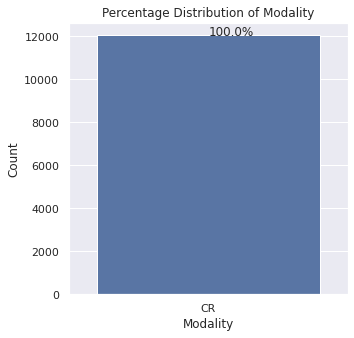

In [ ]:
#Plotting the Modality variable :

plt.figure(figsize=(5,5))
sns.set(style='darkgrid')
sns.countplot('Modality', data=train_metaData, order=train_metaData['Modality'].value_counts().index)
for i in range(mod.shape[0]):
    range_count = mod[i]
    per = round(((range_count*100)/train_metaData.shape[0]),2)
    percent='{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Modality')
plt.ylabel('Count')
plt.title('Percentage Distribution of Modality')
plt.show()

Modality is the term used in radiology to refer to one form of imaging. According to wiki, ***Computed radiography*** (CR) cassettes use photo-stimulated luminescence screens to capture the X-ray image, instead of traditional X-ray film. 

As expected, we see all the records having CR as Modality value. Because of this nature, this property is not useful to us.

***Analysing the 'AGE' field:***

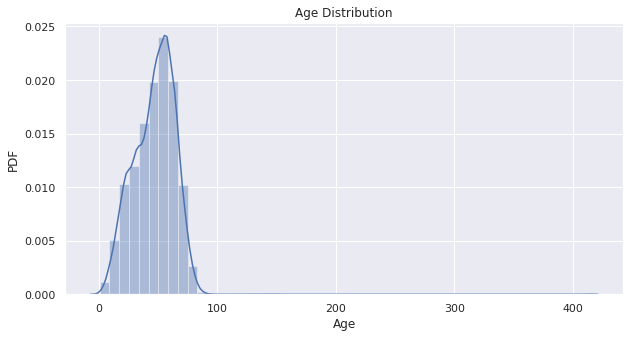

In [ ]:
#Plotting the distribution for the 'age' field :

plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.distplot(train_metaData['Age'])
plt.xlabel('Age')
plt.ylabel('PDF')
plt.title('Age Distribution')
plt.show()

In [ ]:
train_metaData['Age'].describe()

count     12047
unique       93
top          58
freq        365
Name: Age, dtype: object

In [ ]:
age = train_metaData["Age"].value_counts()
print(age)

58     365
57     314
51     303
55     295
52     290
      ... 
148      1
1        1
94       1
90       1
413      1
Name: Age, Length: 93, dtype: int64


We see that the distribution of the 'age' peaked at 58 as it has the maximum count for it. A more common bracket of age is 50-60.

We also see 1 record with age as 413 and that could be an outlier. 

***Analysing the Occurence of Pneumothorax and Gender together:***

In [ ]:
train_metaData_dis_gender= train_metaData.groupby(['Pneumothorax','Gender']).count()
train_metaData_dis_gender.reset_index(inplace=True)

In [ ]:
train_metaData_dis_gender.head()

Pneumothorax Gender  ImageId   Age  Modality  ViewPosition
0           No      F     4241  4241      4241          4241
1           No      M     5137  5137      5137          5137
2          Yes      F     1180  1180      1180          1180
3          Yes      M     1489  1489      1489          1489

Text(0, 0.5, 'Counts')

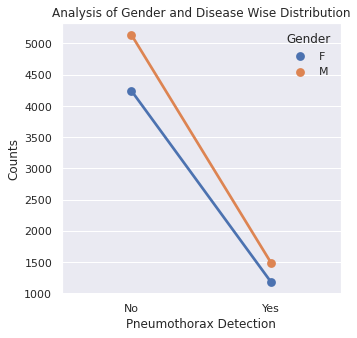

In [ ]:
#Plotting the 'Pneumothorax' and 'Gender' :

plt.figure(figsize=(5,5))
sns.set(style = 'darkgrid')
sns.pointplot(data=train_metaData_dis_gender,x='Pneumothorax',y='Age',hue='Gender');
plt.title('Analysis of Gender and Disease Wise Distribution');
plt.xlabel('Pneumothorax Detection')
plt.ylabel('Counts')

The above plot only shows that Male has more occurences of the disease as compared to Female. 

Let's draw a pie chart to understand more clearly!

In [ ]:
healthy_male = len(train_metaData[(train_metaData['Gender'] == 'M') & (train_metaData['Pneumothorax']== 'No')])
healthy_female = len(train_metaData[(train_metaData['Gender'] == 'F') & (train_metaData['Pneumothorax']== 'No')])
sick_male = len(train_metaData[(train_metaData['Gender'] == 'M') & (train_metaData['Pneumothorax']== 'Yes')])
sick_female = len(train_metaData[(train_metaData['Gender'] == 'F') & (train_metaData['Pneumothorax']== 'Yes')])

total_male = len(train_metaData[train_metaData['Gender'] == 'M'])
total_female = len(train_metaData[train_metaData['Gender'] == 'F'])

print('Total Male : ', total_male)
print('Total Healthy Male : {} ({}%) '.format(healthy_male,round(healthy_male/total_male, 3)*100))
print('Total Sick Male : {} ({}%)'.format(sick_male,round(sick_male/total_male, 3)*100))
print('----------------------------------------')
print('Total Female : ', total_female)
print('Total Healthy Female : {} ({}%) '.format(healthy_female,round(healthy_female/total_female, 3)*100))
print('Total Sick Female : {} ({}%) '.format(sick_female,round(sick_female/total_female, 3)*100))

Total Male :  6626
Total Healthy Male : 5137 (77.5%) 
Total Sick Male : 1489 (22.5%)
----------------------------------------
Total Female :  5421
Total Healthy Female : 4241 (78.2%) 
Total Sick Female : 1180 (21.8%) 


We see that there are ***309 more males*** who have pneumothorax as compared to female. Since the gap is not significantly high, we **cannot conclude positively** that Pneumothorax affects one gender more than the other.

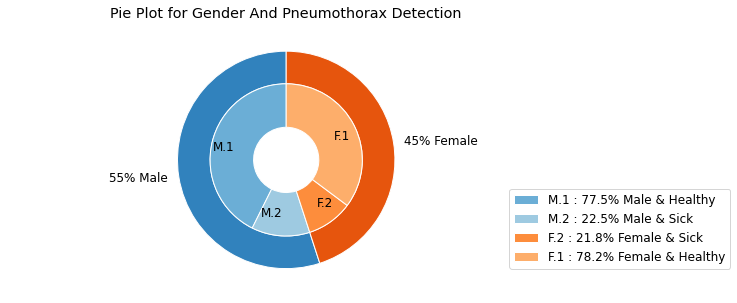

In [ ]:
#https://matplotlib.org/3.3.4/gallery/pie_and_polar_charts/nested_pie.html
#https://stackoverflow.com/questions/55267993/add-legends-to-nested-pie-charts


group_names=["55% Male", "45% Female"]
subgroup_names = ["M.1", "M.2","F.2", "F.1"]
subgroup_names_legends = ["M.1 : 77.5% Male & Healthy", "M.2 : 22.5% Male & Sick","F.2 : 21.8% Female & Sick", "F.1 : 78.2% Female & Healthy"]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axis('equal')
size = 0.3

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap([1, 2, 5, 6])

mypie,_ = ax.pie([total_male,total_female], radius=1, colors=outer_colors, labels=group_names,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)
plt.setp( mypie, width=0.3, edgecolor='white')

mypie2,_ =  ax.pie([healthy_male,sick_male,sick_female,healthy_female], radius=1-size, colors=inner_colors,labels=subgroup_names, labeldistance=0.7,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)
plt.setp( mypie2, width=0.4, edgecolor='white')

ax.set(aspect="equal", title='Pie Plot for Gender And Pneumothorax Detection')
plt.rcParams['font.size'] = 12.0

plt.legend(loc=(0.9, 0.1))
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[2:], subgroup_names_legends, loc=(0.9, 0.1))
plt.show()

To summarize the plot :

1) We have 55% records as Male and the rest 45% as Female.

2) Out of that 55% record of Male, we have 77.5% as Healthy and 22.5% with pneumothorax detection.

3) Out of the 45% record of Female, we have 78.2% as Healthy and 21.8% with pneumothorax detection.

***Analysing the ViewPosition and Occurence of Pneumothorax as parameters together :***

In [ ]:
train_metaData_dis_pos= train_metaData.groupby(['Pneumothorax','ViewPosition']).count()
train_metaData_dis_pos.reset_index(inplace=True)
train_metaData_dis_pos.head()

Pneumothorax ViewPosition  ImageId  Gender   Age  Modality
0           No           AP     3801    3801  3801      3801
1           No           PA     5577    5577  5577      5577
2          Yes           AP      972     972   972       972
3          Yes           PA     1697    1697  1697      1697

Text(0, 0.5, 'Counts')

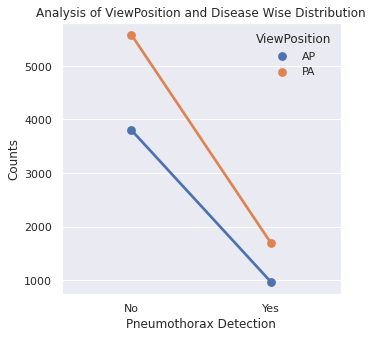

In [ ]:
#Plotting the 'viewPosition' and 'gender' :
plt.figure(figsize=(5,5))
sns.set(style = 'darkgrid')
sns.pointplot(data=train_metaData_dis_pos,x='Pneumothorax',y='Age',hue='ViewPosition');
plt.title('Analysis of ViewPosition and Disease Wise Distribution');
plt.xlabel('Pneumothorax Detection')
plt.ylabel('Counts')

As expected we have more records for PA viewPosition for both condition of the target variable.

Let's draw a pie chart to understand more clearly!

In [ ]:
healthy_ap = len(train_metaData[(train_metaData['ViewPosition'] == 'AP') & (train_metaData['Pneumothorax']== 'No')])
healthy_pa = len(train_metaData[(train_metaData['ViewPosition'] == 'PA') & (train_metaData['Pneumothorax']== 'No')])
sick_ap = len(train_metaData[(train_metaData['ViewPosition'] == 'AP') & (train_metaData['Pneumothorax']== 'Yes')])
sick_pa = len(train_metaData[(train_metaData['ViewPosition'] == 'PA') & (train_metaData['Pneumothorax']== 'Yes')])

total_ap = len(train_metaData[train_metaData['ViewPosition'] == 'AP'])
total_pa = len(train_metaData[train_metaData['ViewPosition'] == 'PA'])

print('Total View Position = AP : ', total_ap)
print('Total Healthy AP : {} ({}%) '.format(healthy_ap,round(healthy_ap/total_ap, 2)*100))
print('Total Sick AP : {} ({}%)'.format(sick_ap,round(sick_ap/total_ap, 3)*100))
print('----------------------------------------')
print('Total View Position = PA : ', total_pa)
print('Total Healthy PA : {} ({}%) '.format(healthy_pa,round(healthy_pa/total_pa, 3)*100))
print('Total Sick PA : {} ({}%) '.format(sick_pa,round(sick_pa/total_pa, 3)*100))

Total View Position = AP :  4773
Total Healthy AP : 3801 (80.0%) 
Total Sick AP : 972 (20.4%)
----------------------------------------
Total View Position = PA :  7274
Total Healthy PA : 5577 (76.7%) 
Total Sick PA : 1697 (23.3%) 



We see that there are 725 more records with PA as viewPosition parameter value who have pneumothorax as compared to AP. 

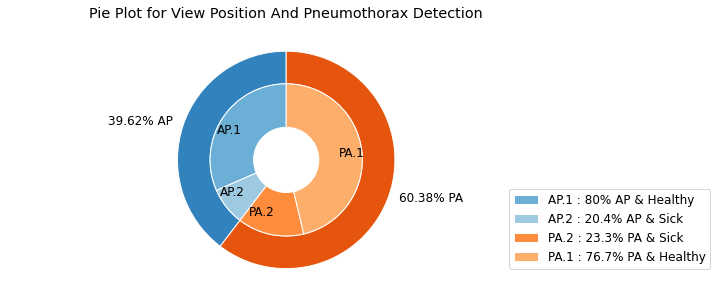

In [ ]:
#https://matplotlib.org/3.3.4/gallery/pie_and_polar_charts/nested_pie.html
#https://stackoverflow.com/questions/55267993/add-legends-to-nested-pie-charts


group_names=["39.62% AP", "60.38% PA"]
subgroup_names = ["AP.1", "AP.2","PA.2", "PA.1"]
subgroup_names_legends = ["AP.1 : 80% AP & Healthy", "AP.2 : 20.4% AP & Sick","PA.2 : 23.3% PA & Sick", "PA.1 : 76.7% PA & Healthy"]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axis('equal')
size = 0.3

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap([1, 2, 5, 6])

mypie,_ = ax.pie([total_ap,total_pa], radius=1, colors=outer_colors, labels=group_names,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)
plt.setp( mypie, width=0.3, edgecolor='white')

mypie2,_ =  ax.pie([healthy_ap,sick_ap,sick_pa,healthy_pa], radius=1-size, colors=inner_colors,labels=subgroup_names, labeldistance=0.7,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)
plt.setp( mypie2, width=0.4, edgecolor='white')

ax.set(aspect="equal", title='Pie Plot for View Position And Pneumothorax Detection')
plt.rcParams['font.size'] = 12.0

plt.legend(loc=(0.9, 0.1))
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[2:], subgroup_names_legends, loc=(0.9, 0.1))
plt.show()

To summarise the plot:

1) There are 60.38% records with PA as viewPosition and 39.62% records with AP.

2) Out of all the records for PA, 76.7% are Healthy with no Pneumothorax Detection. Remaining 23.3% records have the disease in them.

3) Out of all the records for AP, 80% are Healthy with no Pneumothorax Detection. Remaining 20.4% records have the disease in them.

# Preprocessing : 

***Convert the Dicom Images to PNG format :***

In [ ]:
os.getcwd()

'/content/drive/My Drive/Self Case Study 2/DATASET'

In [ ]:
#To check how many images we have in the Train directory :

traindir = os.getcwd()+'/Train Dataset/siim/train_dicom_images/'
test_list = [os.path.basename(x) for x in glob2.glob(traindir + './*.dcm')]
print(len(test_list)) 

12089


In the Train directory, we have a total of 12089 images. We know that there are some duplicates there so we cannot directly use this train directory as the path in the function for image type conversion.

Instead, we will use the ImagePath column of the train.csv file to access the unique images from this train folder.

In [34]:
# Creating folders for .png files

train_png_dest = r'Train Dataset\siim\train_png_images'
#test_png_dest = 'Train Dataset/siim/test_png_images'

if not os.path.isdir(train_png_dest):
    os.makedirs(train_png_dest)
'''if not os.path.isdir(test_png_dest):
    os.makedirs(test_png_dest)'''

'if not os.path.isdir(test_png_dest):\n    os.makedirs(test_png_dest)'

In [ ]:
# Creating folders for .png files

train_png_dest = 'Train Dataset/siim/train_png_images'
#test_png_dest = 'Train Dataset/siim/test_png_images'

if not os.path.isdir(train_png_dest):
    os.makedirs(train_png_dest)
'''if not os.path.isdir(test_png_dest):
    os.makedirs(test_png_dest)'''

In [31]:
##https://www.kaggle.com/onealbao/dicom-to-jpeg-conversion-kernel

def dicom2png(file):
    '''
    This function inputs the path of the image to be read
    and create a .png format for the same image and store in the path created.
    '''
    ds = pydicom.read_file(str(file))
    img = ds.pixel_array
    # formatting the image to make training the network faster.
    img = cv2.resize(img, (256,256) )
    fname = file.replace('.dcm','.png')
    fname = fname.replace('_dicom','_png')
    cv2.imwrite(fname, img)

In [ ]:
# Converting the Train Images :

for file in tqdm(train_df['ImagePath']):
    dicom2png(file)

Streaming output truncated to the last 5000 lines.

 79%|███████▉  | 9548/12047 [1:29:58<21:48,  1.91it/s]

 79%|███████▉  | 9549/12047 [1:29:59<22:09,  1.88it/s]

 79%|███████▉  | 9550/12047 [1:29:59<23:11,  1.79it/s]

 79%|███████▉  | 9551/12047 [1:30:00<24:07,  1.72it/s]

 79%|███████▉  | 9552/12047 [1:30:00<24:00,  1.73it/s]

 79%|███████▉  | 9553/12047 [1:30:01<23:46,  1.75it/s]

 79%|███████▉  | 9554/12047 [1:30:02<23:54,  1.74it/s]

 79%|███████▉  | 9555/12047 [1:30:02<24:02,  1.73it/s]

 79%|███████▉  | 9556/12047 [1:30:03<24:05,  1.72it/s]

 79%|███████▉  | 9557/12047 [1:30:03<23:07,  1.79it/s]

 79%|███████▉  | 9558/12047 [1:30:04<24:44,  1.68it/s]

 79%|███████▉  | 9559/12047 [1:30:05<24:46,  1.67it/s]

 79%|███████▉  | 9560/12047 [1:30:05<25:08,  1.65it/s]

 79%|███████▉  | 9561/12047 [1:30:06<24:43,  1.68it/s]

 79%|███████▉  | 9562/12047 [1:30:06<25:56,  1.60it/s]

 79%|███████▉  | 9563/12047 [1:30:07<25:17,  1.64it/s]

 79%|███████▉  | 9564/12047 [1:30:08<25:07,  1.65it/

In [ ]:
print(os.listdir('Train Dataset/siim/train_png_images/')[10])

1.2.276.0.7230010.3.1.4.8323329.3514.1517875178.176496.png


In [35]:
for file in tqdm(train_df['ImagePath']):
    dicom2png(file)


  1%|█▊                                                                                                                          | 172/12047 [00:07<13:52, 14.26it/s]


  2%|██▊                                                                                                                         | 271/12047 [00:16<19:34, 10.02it/s]


  3%|███▊                                                                                                                        | 367/12047 [00:25<16:05, 12.10it/s]


  4%|████▊                                                                                                                       | 469/12047 [00:34<15:17, 12.62it/s]


  5%|█████▊                                                                                                                      | 561/12047 [00:43<18:02, 10.61it/s]


  5%|██████▊                                                                                                                     | 657/12047 [00:53<26:44,  7.10it/s]


  6%|███████▊                                                                                                                    | 759/12047 [01:01<16:55, 11.12it/s]


  7%|████████▊                                                                                                                   | 862/12047 [01:11<14:51, 12.55it/s]


  8%|█████████▊                                                                                                                  | 953/12047 [01:20<22:43,  8.14it/s]


  9%|██████████▌                                                                                                                | 1033/12047 [01:29<21:46,  8.43it/s]


  9%|███████████▎                                                                                                               | 1106/12047 [01:43<49:45,  3.67it/s]


 10%|███████████▉                                                                                                               | 1165/12047 [01:54<53:05,  3.42it/s]


 10%|████████████▊                                                                                                              | 1249/12047 [02:04<22:28,  8.01it/s]


 11%|█████████████▋                                                                                                             | 1340/12047 [02:13<13:15, 13.46it/s]


 12%|██████████████▌                                                                                                            | 1425/12047 [02:22<32:23,  5.47it/s]


 13%|███████████████▌                                                                                                           | 1520/12047 [02:30<11:35, 15.14it/s]


 13%|████████████████▍                                                                                                          | 1615/12047 [02:40<16:35, 10.48it/s]


 14%|█████████████████▍                                                                                                         | 1712/12047 [02:48<15:42, 10.96it/s]


 15%|██████████████████▌                                                                                                        | 1816/12047 [02:57<10:33, 16.15it/s]


 16%|███████████████████▌                                                                                                       | 1920/12047 [03:06<13:55, 12.12it/s]


 17%|████████████████████▌                                                                                                      | 2013/12047 [03:15<17:01,  9.82it/s]


 18%|█████████████████████▌                                                                                                     | 2118/12047 [03:24<13:32, 12.22it/s]


 18%|██████████████████████▋                                                                                                    | 2225/12047 [03:32<09:17, 17.63it/s]


 19%|███████████████████████▊                                                                                                   | 2327/12047 [03:41<14:45, 10.98it/s]


 20%|████████████████████████▊                                                                                                  | 2426/12047 [03:50<13:18, 12.05it/s]


 21%|█████████████████████████▊                                                                                                 | 2523/12047 [03:59<16:10,  9.82it/s]


 22%|██████████████████████████▊                                                                                                | 2626/12047 [04:08<14:09, 11.09it/s]


 23%|███████████████████████████▊                                                                                               | 2726/12047 [04:17<13:55, 11.16it/s]


 23%|████████████████████████████▋                                                                                              | 2812/12047 [04:26<13:54, 11.06it/s]


 24%|█████████████████████████████▋                                                                                             | 2905/12047 [04:35<12:44, 11.95it/s]


 25%|██████████████████████████████▋                                                                                            | 3005/12047 [04:44<11:20, 13.30it/s]


 26%|███████████████████████████████▋                                                                                           | 3104/12047 [04:53<10:29, 14.21it/s]


 27%|████████████████████████████████▋                                                                                          | 3201/12047 [05:02<18:28,  7.98it/s]


 27%|█████████████████████████████████▌                                                                                         | 3293/12047 [05:10<13:04, 11.15it/s]


 28%|██████████████████████████████████▋                                                                                        | 3396/12047 [05:19<12:14, 11.77it/s]


 29%|███████████████████████████████████▋                                                                                       | 3494/12047 [05:28<09:46, 14.58it/s]


 30%|████████████████████████████████████▋                                                                                      | 3593/12047 [05:38<15:19,  9.19it/s]


 31%|█████████████████████████████████████▌                                                                                     | 3684/12047 [05:48<12:40, 10.99it/s]


 31%|██████████████████████████████████████▌                                                                                    | 3783/12047 [05:58<13:46, 10.00it/s]


 32%|███████████████████████████████████████▌                                                                                   | 3878/12047 [06:07<09:25, 14.45it/s]


 33%|████████████████████████████████████████▌                                                                                  | 3976/12047 [06:17<20:31,  6.55it/s]


 34%|█████████████████████████████████████████▌                                                                                 | 4074/12047 [06:27<13:56,  9.53it/s]


 35%|██████████████████████████████████████████▋                                                                                | 4175/12047 [06:36<12:29, 10.51it/s]


 35%|███████████████████████████████████████████▌                                                                               | 4272/12047 [06:46<13:14,  9.78it/s]


 36%|████████████████████████████████████████████▌                                                                              | 4367/12047 [06:56<19:30,  6.56it/s]


 37%|█████████████████████████████████████████████▎                                                                             | 4441/12047 [07:06<21:31,  5.89it/s]


 37%|██████████████████████████████████████████████                                                                             | 4506/12047 [07:19<24:58,  5.03it/s]


 38%|██████████████████████████████████████████████▊                                                                            | 4587/12047 [07:28<11:04, 11.22it/s]


 39%|███████████████████████████████████████████████▊                                                                           | 4683/12047 [07:39<08:13, 14.92it/s]


 40%|████████████████████████████████████████████████▊                                                                          | 4784/12047 [07:49<14:16,  8.48it/s]


 41%|█████████████████████████████████████████████████▊                                                                         | 4882/12047 [07:59<11:38, 10.26it/s]


 41%|██████████████████████████████████████████████████▊                                                                        | 4976/12047 [08:08<12:47,  9.22it/s]


 42%|███████████████████████████████████████████████████▊                                                                       | 5074/12047 [08:18<12:33,  9.25it/s]


 43%|████████████████████████████████████████████████████▊                                                                      | 5172/12047 [08:27<06:24, 17.89it/s]


 44%|█████████████████████████████████████████████████████▊                                                                     | 5273/12047 [08:37<09:00, 12.54it/s]


 45%|██████████████████████████████████████████████████████▊                                                                    | 5373/12047 [08:47<12:47,  8.69it/s]


 45%|███████████████████████████████████████████████████████▊                                                                   | 5472/12047 [08:58<23:13,  4.72it/s]


 46%|████████████████████████████████████████████████████████▉                                                                  | 5571/12047 [09:06<08:27, 12.75it/s]


 47%|█████████████████████████████████████████████████████████▉                                                                 | 5677/12047 [09:15<13:06,  8.09it/s]


 48%|██████████████████████████████████████████████████████████▉                                                                | 5775/12047 [09:25<12:03,  8.67it/s]


 49%|███████████████████████████████████████████████████████████▉                                                               | 5873/12047 [09:34<07:39, 13.44it/s]


 50%|█████████████████████████████████████████████████████████████                                                              | 5976/12047 [09:43<09:00, 11.24it/s]


 50%|█████████████████████████████████████████████████████████████▉                                                             | 6071/12047 [09:53<08:36, 11.57it/s]


 51%|██████████████████████████████████████████████████████████████▉                                                            | 6170/12047 [10:03<08:04, 12.13it/s]


 52%|████████████████████████████████████████████████████████████████                                                           | 6269/12047 [10:13<08:52, 10.84it/s]


 53%|████████████████████████████████████████████████████████████████▊                                                          | 6346/12047 [10:23<27:03,  3.51it/s]


 53%|█████████████████████████████████████████████████████████████████▎                                                         | 6402/12047 [10:32<16:50,  5.58it/s]


 54%|█████████████████████████████████████████████████████████████████▉                                                         | 6461/12047 [10:41<11:34,  8.04it/s]


 54%|██████████████████████████████████████████████████████████████████▉                                                        | 6553/12047 [10:50<11:40,  7.84it/s]


 55%|███████████████████████████████████████████████████████████████████▉                                                       | 6652/12047 [11:00<08:42, 10.33it/s]


 56%|████████████████████████████████████████████████████████████████████▉                                                      | 6748/12047 [11:10<08:38, 10.23it/s]


 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 6849/12047 [11:19<06:58, 12.42it/s]


 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 6947/12047 [11:29<09:31,  8.93it/s]


 59%|███████████████████████████████████████████████████████████████████████▉                                                   | 7050/12047 [11:38<10:13,  8.14it/s]


 59%|████████████████████████████████████████████████████████████████████████▉                                                  | 7149/12047 [11:46<05:41, 14.33it/s]


 60%|██████████████████████████████████████████████████████████████████████████                                                 | 7248/12047 [11:55<07:48, 10.24it/s]


 61%|███████████████████████████████████████████████████████████████████████████                                                | 7349/12047 [12:03<05:52, 13.34it/s]


 62%|████████████████████████████████████████████████████████████████████████████                                               | 7452/12047 [12:13<07:09, 10.69it/s]


 63%|█████████████████████████████████████████████████████████████████████████████▏                                             | 7558/12047 [12:22<05:33, 13.48it/s]


 64%|██████████████████████████████████████████████████████████████████████████████▏                                            | 7660/12047 [12:31<05:48, 12.60it/s]


 64%|███████████████████████████████████████████████████████████████████████████████▏                                           | 7757/12047 [12:42<10:46,  6.63it/s]


 65%|███████████████████████████████████████████████████████████████████████████████▊                                           | 7814/12047 [12:51<11:20,  6.22it/s]


 65%|████████████████████████████████████████████████████████████████████████████████▎                                          | 7868/12047 [13:00<08:37,  8.08it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████                                          | 7939/12047 [13:08<05:31, 12.41it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 8039/12047 [13:17<07:01,  9.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████                                        | 8139/12047 [13:26<05:33, 11.71it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████                                       | 8238/12047 [13:36<07:52,  8.07it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                     | 8340/12047 [13:44<05:52, 10.53it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                    | 8445/12047 [13:53<04:56, 12.15it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████▎                                   | 8546/12047 [14:01<04:08, 14.10it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████▎                                  | 8651/12047 [14:09<04:55, 11.51it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████▎                                 | 8751/12047 [14:18<03:58, 13.83it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████▍                                | 8855/12047 [14:28<14:13,  3.74it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                               | 8952/12047 [14:37<04:20, 11.86it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 9045/12047 [14:47<04:39, 10.74it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9148/12047 [14:56<04:18, 11.20it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▍                            | 9249/12047 [15:06<06:51,  6.81it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▌                           | 9356/12047 [15:14<03:38, 12.30it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9460/12047 [15:23<07:24,  5.82it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9563/12047 [15:31<03:25, 12.08it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 9666/12047 [15:39<02:30, 15.82it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 9771/12047 [15:47<02:14, 16.86it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9875/12047 [15:56<03:40,  9.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9984/12047 [16:03<02:47, 12.35it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10088/12047 [16:13<02:23, 13.68it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10187/12047 [16:22<02:33, 12.13it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 10260/12047 [16:31<04:29,  6.63it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 10313/12047 [16:40<04:56,  5.84it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10366/12047 [16:48<03:51,  7.26it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 10456/12047 [16:56<01:57, 13.51it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10555/12047 [17:05<02:37,  9.50it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 10656/12047 [17:14<02:06, 10.98it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 10754/12047 [17:24<01:52, 11.54it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 10843/12047 [17:34<01:46, 11.26it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 10932/12047 [17:43<02:19,  7.97it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 10995/12047 [17:53<03:37,  4.84it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 11051/12047 [18:01<03:15,  5.11it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 11105/12047 [18:10<02:10,  7.22it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11191/12047 [18:19<01:25,  9.99it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11249/12047 [18:30<05:35,  2.38it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 11299/12047 [18:42<02:41,  4.64it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 11349/12047 [18:53<02:43,  4.27it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11404/12047 [19:02<01:20,  8.04it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11481/12047 [19:11<01:27,  6.50it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 11530/12047 [19:22<02:01,  4.24it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11579/12047 [19:32<01:58,  3.94it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11631/12047 [19:40<00:58,  7.08it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 11680/12047 [19:52<01:30,  4.05it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 11755/12047 [20:01<00:40,  7.19it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11822/12047 [20:12<00:31,  7.13it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11878/12047 [20:27<00:58,  2.90it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 11927/12047 [20:45<00:31,  3.80it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11976/12047 [21:00<00:33,  2.10it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 12025/12047 [21:12<00:03,  5.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12047/12047 [21:18<00:00,  3.94it/s]


In [36]:
print(os.listdir(r'Train Dataset\siim\train_png_images/')[10])

1.2.276.0.7230010.3.1.4.8323329.10009.1517875220.958288.png


In [ ]:
# Converting the Test Images :

for file in tqdm(test_df['ImagePath']):
    dicom2png(file)

Streaming output truncated to the last 5000 lines.

 22%|██▏       | 706/3205 [06:54<23:56,  1.74it/s]

 22%|██▏       | 707/3205 [06:55<23:32,  1.77it/s]

 22%|██▏       | 708/3205 [06:55<26:57,  1.54it/s]

 22%|██▏       | 709/3205 [06:56<25:42,  1.62it/s]

 22%|██▏       | 710/3205 [06:57<25:41,  1.62it/s]

 22%|██▏       | 711/3205 [06:57<25:07,  1.65it/s]

 22%|██▏       | 712/3205 [06:58<24:16,  1.71it/s]

 22%|██▏       | 713/3205 [06:58<24:28,  1.70it/s]

 22%|██▏       | 714/3205 [06:59<24:57,  1.66it/s]

 22%|██▏       | 715/3205 [07:00<24:20,  1.71it/s]

 22%|██▏       | 716/3205 [07:00<23:58,  1.73it/s]

 22%|██▏       | 717/3205 [07:01<24:10,  1.72it/s]

 22%|██▏       | 718/3205 [07:01<22:33,  1.84it/s]

 22%|██▏       | 719/3205 [07:02<21:18,  1.95it/s]

 22%|██▏       | 720/3205 [07:02<22:27,  1.84it/s]

 22%|██▏       | 721/3205 [07:03<24:51,  1.67it/s]

 23%|██▎       | 722/3205 [07:03<23:58,  1.73it/s]

 23%|██▎       | 723/3205 [07:04<23:39,  1.75it/s]

 23%|██▎    

In [ ]:
print(os.listdir('Train Dataset/siim/test_png_images/')[10])

ID_87a258052.png


In [ ]:
# Converting the Test Images :

for file in tqdm(test_df['ImagePath']):
    dicom2png(file)

***Convert RLE to Mask :***

In [37]:
# Creating folders for mask :

train_mask_dest = r'Train Dataset\siim\train_mask_png_images'
#test_mask_dest = 'Train Dataset/siim/test_mask_png_images'

if not os.path.isdir(train_mask_dest):
    os.makedirs(train_mask_dest)
'''if not os.path.isdir(test_mask_dest):
    os.makedirs(test_mask_dest)'''

'if not os.path.isdir(test_mask_dest):\n    os.makedirs(test_mask_dest)'

In [ ]:
# Creating folders for mask :

train_mask_dest = 'Train Dataset/siim/train_mask_png_images'
test_mask_dest = 'Train Dataset/siim/test_mask_png_images'

if not os.path.isdir(train_mask_dest):
    os.makedirs(train_mask_dest)
if not os.path.isdir(test_mask_dest):
    os.makedirs(test_mask_dest)

In [38]:
def rle2mask(rle, width, height):
    '''
    RLE to mask conversion as given.
    It inputs the rle (EncodedPixel value) and return the mask value.
    '''
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height)

In [39]:
def create_masks(data,mask_path,mask_height, mask_width):
    '''
    It inputs the ImageId and EncodedPixel value, 
    path to store the resultant mask 
    and the original width and height of the mask
    '''
    for imageId, encod_pixels in tqdm(data.values):

        # Creating the path name where mask images are stored 
        fname = f"{mask_path}{imageId}_mask.png"

        # RLE values present
        if encod_pixels!= "-1":
            mask = rle2mask(encod_pixels, mask_width, mask_height).T
            mask = cv2.resize(mask, (256,256))
            cv2.imwrite(fname, mask)

        # No RLE values so no pneumothorax found and hence a blank mask is created    
        else:
            mask = np.zeros((256,256), dtype=np.uint8)
            cv2.imwrite(fname, mask)

In [ ]:
# Running the above function to create Masks 

create_masks(train_df[['ImageId',' EncodedPixels']],'Train Dataset/siim/train_mask_png_images/',1024,1024)

100%|██████████| 12047/12047 [01:00<00:00, 199.32it/s]


In [41]:
# Running the above function to create Masks 

create_masks(train_df[['ImageId',' EncodedPixels']],'Train Dataset\\siim\\train_mask_png_images\\',1024,1024)


  3%|███▍                                                                                                                        | 328/12047 [00:08<08:52, 22.02it/s]


  5%|██████▋                                                                                                                     | 649/12047 [00:15<08:05, 23.47it/s]


  9%|██████████▌                                                                                                                | 1037/12047 [00:23<04:42, 38.98it/s]


 13%|███████████████▍                                                                                                           | 1515/12047 [00:30<02:59, 58.63it/s]


 17%|████████████████████▍                                                                                                      | 1996/12047 [00:37<05:26, 30.77it/s]


 18%|██████████████████████▌                                                                                                    | 2208/12047 [00:48<13:04, 12.55it/s]


 20%|████████████████████████▎                                                                                                  | 2382/12047 [00:57<10:39, 15.12it/s]


 23%|████████████████████████████▊                                                                                              | 2825/12047 [01:05<03:41, 41.67it/s]


 26%|████████████████████████████████▌                                                                                          | 3184/12047 [01:14<06:42, 22.03it/s]


 28%|██████████████████████████████████▍                                                                                        | 3369/12047 [01:25<09:32, 15.15it/s]


 31%|█████████████████████████████████████▊                                                                                     | 3706/12047 [01:32<02:20, 59.27it/s]


 35%|███████████████████████████████████████████▎                                                                               | 4242/12047 [01:39<01:43, 75.06it/s]


 37%|██████████████████████████████████████████████                                                                             | 4516/12047 [01:49<05:27, 23.00it/s]


 39%|████████████████████████████████████████████████▌                                                                          | 4756/12047 [01:58<03:51, 31.51it/s]


 42%|███████████████████████████████████████████████████▌                                                                       | 5050/12047 [02:06<01:47, 64.80it/s]


 47%|█████████████████████████████████████████████████████████                                                                 | 5633/12047 [02:13<01:00, 106.39it/s]


 53%|████████████████████████████████████████████████████████████████▊                                                          | 6347/12047 [02:21<01:05, 87.07it/s]


 55%|███████████████████████████████████████████████████████████████████▊                                                       | 6637/12047 [02:30<03:49, 23.60it/s]


 57%|█████████████████████████████████████████████████████████████████████▋                                                     | 6831/12047 [02:39<06:00, 14.46it/s]


 59%|████████████████████████████████████████████████████████████████████████▍                                                  | 7089/12047 [02:48<03:00, 27.50it/s]


 63%|█████████████████████████████████████████████████████████████████████████████▍                                             | 7585/12047 [02:55<00:53, 83.54it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████▊                                         | 8012/12047 [03:03<02:27, 27.30it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████                                      | 8337/12047 [03:11<02:35, 23.86it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8770/12047 [03:20<00:24, 134.90it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 9305/12047 [03:28<01:41, 27.04it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 9632/12047 [03:38<01:08, 35.30it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10221/12047 [03:46<00:21, 86.59it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 10837/12047 [03:53<00:15, 75.86it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11249/12047 [04:02<00:31, 24.96it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 11556/12047 [04:11<00:16, 30.16it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 11842/12047 [04:21<00:08, 23.78it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12047/12047 [04:28<00:00, 44.92it/s]

***Visualising one image with the mask :***

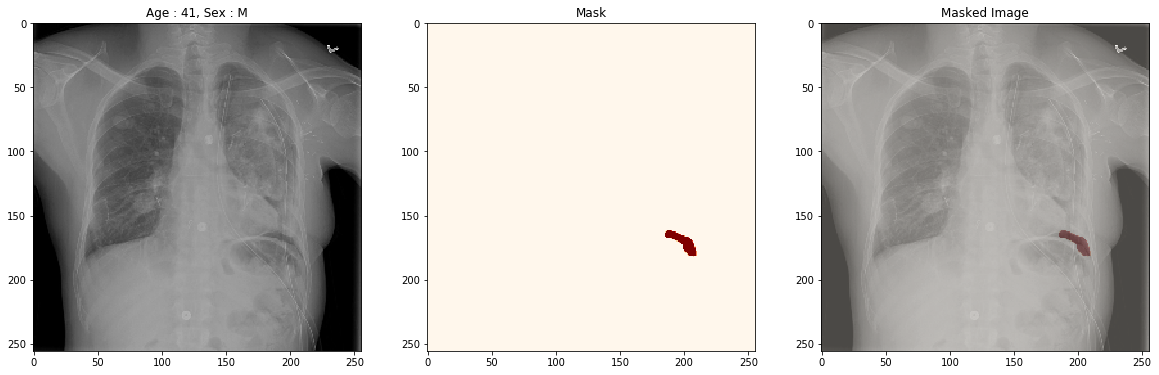

In [42]:
#https://www.kaggle.com/jackinalltrade/jack-siim-tensorflow2/notebook#Primary_Data_Visualization

train_image_raw = pydicom.read_file(train_df['ImagePath'][10])
train_image = train_image_raw.pixel_array
train_image = cv2.resize(train_image, (256, 256))

encod_pixel = train_df[' EncodedPixels'][10]
train_image_mask = rle2mask(encod_pixel, 1024, 1024).T
train_image_mask = cv2.resize(train_image_mask, (256, 256))

fig = plt.figure(figsize=(20,10))
figure = fig.add_subplot(1,3,1)
figure.set_title("Age : {}, Sex : {}".format(train_image_raw.PatientAge, train_image_raw.PatientSex))
plt.imshow(train_image,cmap=plt.cm.gray)

figure = fig.add_subplot(1,3,2)
figure.set_title("Mask")
plt.imshow(train_image_mask,cmap='OrRd', alpha=1)

figure = fig.add_subplot(1,3,3)
figure.set_title("Masked Image")
plt.imshow(train_image,cmap=plt.cm.gray)
plt.imshow(train_image_mask,cmap='OrRd', alpha=0.3)

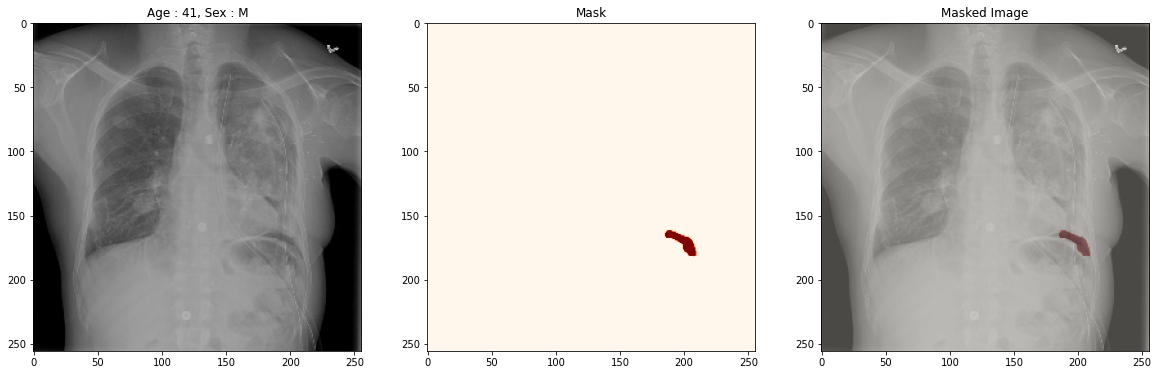

In [ ]:
#https://www.kaggle.com/jackinalltrade/jack-siim-tensorflow2/notebook#Primary_Data_Visualization

train_image_raw = pydicom.read_file(train_df['ImagePath'][10])
train_image = train_image_raw.pixel_array
train_image = cv2.resize(train_image, (256, 256))

encod_pixel = train_df[' EncodedPixels'][10]
train_image_mask = rle2mask(encod_pixel, 1024, 1024).T
train_image_mask = cv2.resize(train_image_mask, (256, 256))

fig = plt.figure(figsize=(20,10))
figure = fig.add_subplot(1,3,1)
figure.set_title("Age : {}, Sex : {}".format(train_image_raw.PatientAge, train_image_raw.PatientSex))
plt.imshow(train_image,cmap=plt.cm.gray)

figure = fig.add_subplot(1,3,2)
figure.set_title("Mask")
plt.imshow(train_image_mask,cmap='OrRd', alpha=1)

figure = fig.add_subplot(1,3,3)
figure.set_title("Masked Image")
plt.imshow(train_image,cmap=plt.cm.gray)
plt.imshow(train_image_mask,cmap='OrRd', alpha=0.3)


***Storing all the paths for each image in the .csv file  :***

In [ ]:
train_df['MaskPath'] = 'Train Dataset/siim/train_mask_png_images/'+ train_df['ImageId']+'_mask.png'
train_df['ImagePath_Png'] = 'Train Dataset/siim/train_png_images/'+ train_df['ImageId']+'.png'

In [ ]:
# Final Train Dataset :

train_df.head(2)

ImageId  ...                                      ImagePath_Png
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...  ...  Train Dataset/siim/train_png_images/1.2.276.0....
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...  ...  Train Dataset/siim/train_png_images/1.2.276.0....

[2 rows x 5 columns]

***Saving the final train dataset into a .csv file to be used later :***

In [ ]:
train_df.to_csv("Train Dataset/siim/final_train_data.csv", index=False)

In [ ]:
final_train_df = pd.read_csv("Train Dataset/siim/final_train_data.csv")
final_train_df.head(2)

ImageId  ...                                      ImagePath_Png
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...  ...  Train Dataset/siim/train_png_images/1.2.276.0....
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...  ...  Train Dataset/siim/train_png_images/1.2.276.0....

[2 rows x 5 columns]

In [ ]:
#https://www.kaggle.com/reemrashwan/u-net-to-predict-pneumothorax#Model

#https://www.kaggle.com/meaninglesslives/nested-unet-with-efficientnet-encoder#Predict-the-validation-set-to-do-a-sanity-check